# archパッケージのForecastingを使ってみる

[Forecasting](https://arch.readthedocs.io/en/latest/univariate/forecasting.html)

### Analytical forecasts

### Simulation-based forecasts
- 多分、`model.forecast(method='simulation')`と`model.simulate()`は同じ。だから「seq-data-analysis-training-08-VaR-simulation.ipynb」でやったのはこれ。

### Bootstrap-based forecasts

In [1]:
%matplotlib inline

import arch
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
import statsmodels.tsa as tsa
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [2]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

prods = ['S&P500先物', '金先物']

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [3]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100


# 2019年の1年間のみのデータ

In [4]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 1, 1)] for df in rr_dfs]

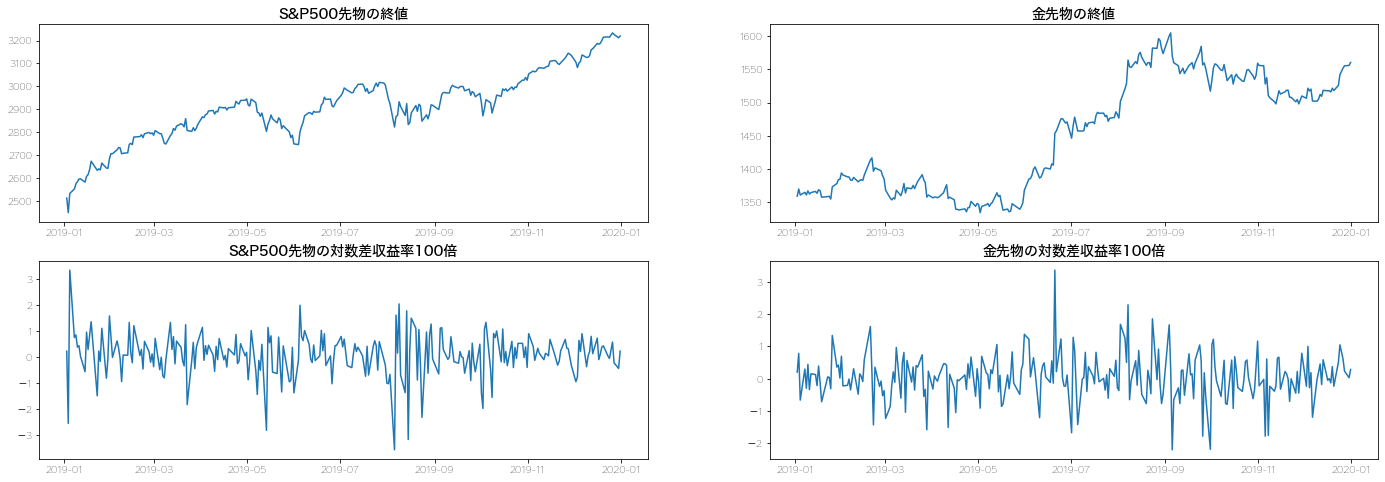

In [5]:
# 比較のため価格と対数差収益率を可視化しておく
fig, ax = plt.subplots(2, 2, figsize=(24,8))
for i, prod in enumerate(prods):
    ax[0,i].plot(rrdfs2019[i].index, rrdfs2019[i]['Close'])
    ax[0,i].set_title(f'{prod}の終値', fontsize=14, fontweight='semibold')
    ax[1,i].plot(rrdfs2019[i].index, rrdfs2019[i]['logCDiff'])
    ax[1,i].set_title(f'{prod}の対数差収益率100倍', fontsize=14, fontweight='semibold')

# EGARCHモデルのあてはめ

現状最もAICが小さいモデルはEGARCHのため、これを使う。

S%P500先物データにEGARCHを使う根拠
- 定常時系列とみなせる（ARXモデルを使うための条件）
    - Dicker-Fuller検定にかけた結果、単位根を持つという帰無仮説を棄却できたため
- 分散不均一性を持つ（ARCH/GARCH等を使うための条件）
    - ARモデルにあてはめたところ、誤差分散（残差の2乗）系列に時間依存構造があったため
- 価格の上昇・下落に対してボラティリティ変動が非対称だと想定される
    - 株式市場では一般に、価格が上昇した時より下落したときにボラティリティが上昇することが知られているため

In [6]:
egarch_models = [arch.arch_model(df['logCDiff'], vol='EGARCH', dist='gaussian', p=1, o=1, q=1) for df in rrdfs2019]
egaresults = [am.fit(disp='off') for am in egarch_models]
_ = [print(f'{prod}にEGARCH(1,1,1)モデルを当てはめたときのAIC：{res.aic}') for res, prod in zip(egaresults, prods)]

S&P500先物にEGARCH(1,1,1)モデルを当てはめたときのAIC：542.7985676455792
金先物にEGARCH(1,1,1)モデルを当てはめたときのAIC：505.5654876375514


In [7]:
egarch_models[0].forecast??

Object `forecast` not found.


In [9]:
egarch_models[0].simulate

SyntaxError: invalid syntax (<ipython-input-9-b6e9d9dee7d3>, line 1)

In [ ]:
egarch_models[0].simulate